## This file makes machine learning application for aggregation packets for UNSW IEEE TMC 2018  dataset with 4 diffirent group size (3, 6, 9, 12)
### Used machine learning algorithms: RF (Random Forest)

-------------

###  importing relevant libraries

In [1]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import csv
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report




### train and test datasets

In [4]:
loop="UNSW_benign_h_train_sk.csv"
loop2="UNSW_benign_h_test_sk.csv"

In [4]:
df = pd.read_csv(loop)
df

,ARP,LLC,EAPOL,IP,ICMP,ICMP6,TCP,UDP,TCP_w_size,HTTP,...,IP_padding,IP_add_count,IP_ralert,Portcl_src,Portcl_dst,Pck_size,Pck_rawdata,Entropy,Label,Mac
0,0,0,0,1,0,0,1,0,1734,0,...,0,68,0,3,1,81,1,5.259991,Amazon Echo,44:65:0d:56:cc:d3
1,0,0,0,1,0,0,1,0,1369,0,...,0,64,0,3,1,40,0,0.000000,Amazon Echo,44:65:0d:56:cc:d3
2,0,0,0,1,0,0,1,0,744,1,...,0,36,0,3,1,52,0,0.000000,Amazon Echo,44:65:0d:56:cc:d3
3,0,0,0,1,0,0,0,1,0,0,...,0,65,0,2,2,177,1,5.845293,Amazon Echo,44:65:0d:56:cc:d3
4,0,0,0,1,0,0,1,0,639,0,...,0,64,0,2,1,366,1,7.233723,Amazon Echo,44:65:0d:56:cc:d3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309995,0,0,0,1,0,0,0,1,0,0,...,0,13,0,2,2,149,1,3.682847,unknown maybe cam,e8:ab:fa:19:de:4f
309996,0,0,0,1,0,0,0,1,0,0,...,0,16,0,2,2,149,1,3.682847,unknown maybe cam,e8:ab:fa:19:de:4f
309997,0,0,0,1,0,0,0,1,0,0,...,0,15,0,3,2,88,1,5.502480,unknown maybe cam,e8:ab:fa:19:de:4f
309998,0,0,0,1,0,0,0,1,0,0,...,0,1,0,1,1,320,0,0.000000,unknown maybe cam,e8:ab:fa:19:de:4f


### Discovering Labels

In [6]:
def target_names():
    name=loop
    df = pd.read_csv(name)
    target_names=sorted(list(df[df.columns[-2]].unique()))
    return target_names
target_names=target_names()
target_names

['Amazon Echo',
 'Android Phone 1',
 'Android Phone 2',
 'Belkin Wemo switch',
 'Belkin wemo motion sensor',
 'Blipcare Blood Pressure meter',
 'Dropcam',
 'HP Printer',
 'IPhone',
 'Insteon Camera',
 'Laptop',
 'Light Bulbs LiFX Smart Bulb',
 'MacBook',
 'MacBook/Iphone',
 'NEST Protect smoke alarm',
 'Nest Dropcam',
 'Netatmo Welcome',
 'Netatmo weather station',
 'PIX-STAR Photo-frame',
 'Samsung Galaxy Tab',
 'Samsung SmartCam',
 'Smart Things',
 'TP-Link Day Night Cloud camera',
 'TP-Link Smart plug',
 'TPLink Router Bridge LAN (Gateway)',
 'Triby Speaker',
 'Withings Aura smart sleep sensor',
 'Withings Smart Baby Monitor',
 'Withings Smart scale',
 'iHome',
 'unknown maybe cam']

### Hyperparameters of machine learning algorithm.

In [2]:
ml_list={"Random Forest R":RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=27.0, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=69,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}


# Aggregation Algorithm

In [9]:
altime=0
def most_frequent(List): 
    return max(set(List), key = List.count) 

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


def merged(mac,y_test,predict):
    step=12
    second=time.time()
    mac_test=[]
    for i in y_test.index:
        mac_test.append(mac[i])

    d_list=sorted(list(mac.unique()))
    devices={}
    for i in d_list:
        devices[i]=[]    


    new_y=[0]*len(y_test)

    for i,ii in enumerate (mac_test):
        devices[ii].append(i)
        #devices[]
    for i in devices:
        
        a = [devices[i][j:j + step] for j in range(0, len(devices[i]), step)]  
        for ii in a:
            step_list=[]
            for iii in ii:
                step_list.append(predict[iii])
            add=most_frequent(list(step_list))
            for iii in ii:
                new_y[iii]=add
                
    return new_y,time.time()-second

## Calculation of evaluations

In [10]:
def score(altime,train_time,test_time,predict,y_test,class_based_results):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))
    #clf.score(X_test, y_test))
    #print(balanced_accuracy_score( y_test,predict))
    #t_time.append(float((time.time()-second)) )
    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),2)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(round(np.mean(test_time)+np.mean(train_time),15))+str(altime)+"\n")
    return lines,class_based_results

# Machine learning applications (100 repetitions)

## GROUP SIZE 1 (= individual packets)

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
h_train_sk.csv  0   1   Random  0.86  0.86  0.93  0.86  0.88  0.86  11.56    1.11    12.67   0.0     
h_train_sk.csv  1   2   Random  0.86  0.86  0.93  0.86  0.88  0.86  10.09    1.2     11.29   0.0     
h_train_sk.csv  2   3   Random  0.86  0.86  0.92  0.86  0.88  0.86  10.99    1.07    12.06   0.0     
h_train_sk.csv  3   4   Random  0.86  0.86  0.93  0.86  0.88  0.86  11.87    1.23    13.1    0.0     
h_train_sk.csv  4   5   Random  0.86  0.86  0.93  0.86  0.88  0.86  10.4     1.13    11.53   0.0     
h_train_sk.csv  5   6   Random  0.86  0.86  0.93  0.86  0.88  0.86  12.0     1.16    13.16   0.0     
h_train_sk.csv  6   7   Random  0.86  0.86  0.93  0.86  0.88  0.86  11.12    1.32    12.43   0.0     
h_train_sk.csv  7   8   Random  0.86  0.86  0.93  0.86  0.88  0.86  10.19    1.05    11.24   0.0     
h_train_sk.csv  8   9   Random  0.86  0.86  0.93  0.86  0.88  0.86  9.67     1.05 

h_train_sk.csv  80  81  Random  0.86  0.86  0.92  0.86  0.88  0.86  9.5      1.04    10.54   0.0     
h_train_sk.csv  81  82  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.62     1.07    10.69   0.0     
h_train_sk.csv  82  83  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.78     1.05    10.82   0.0     
h_train_sk.csv  83  84  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.88     1.05    10.93   0.0     
h_train_sk.csv  84  85  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.59     1.05    10.64   0.0     
h_train_sk.csv  85  86  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.58     1.06    10.64   0.0     
h_train_sk.csv  86  87  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.55     1.14    10.69   0.0     
h_train_sk.csv  87  88  Random  0.86  0.86  0.93  0.86  0.88  0.86  11.33    1.39    12.73   0.0     
h_train_sk.csv  88  89  Random  0.86  0.86  0.93  0.86  0.88  0.86  11.21    1.05    12.25   0.0     
h_train_sk.csv  89  90  Random  0.86  0.86  0.93  0.86  0.88  0.86  9.6      1.03 

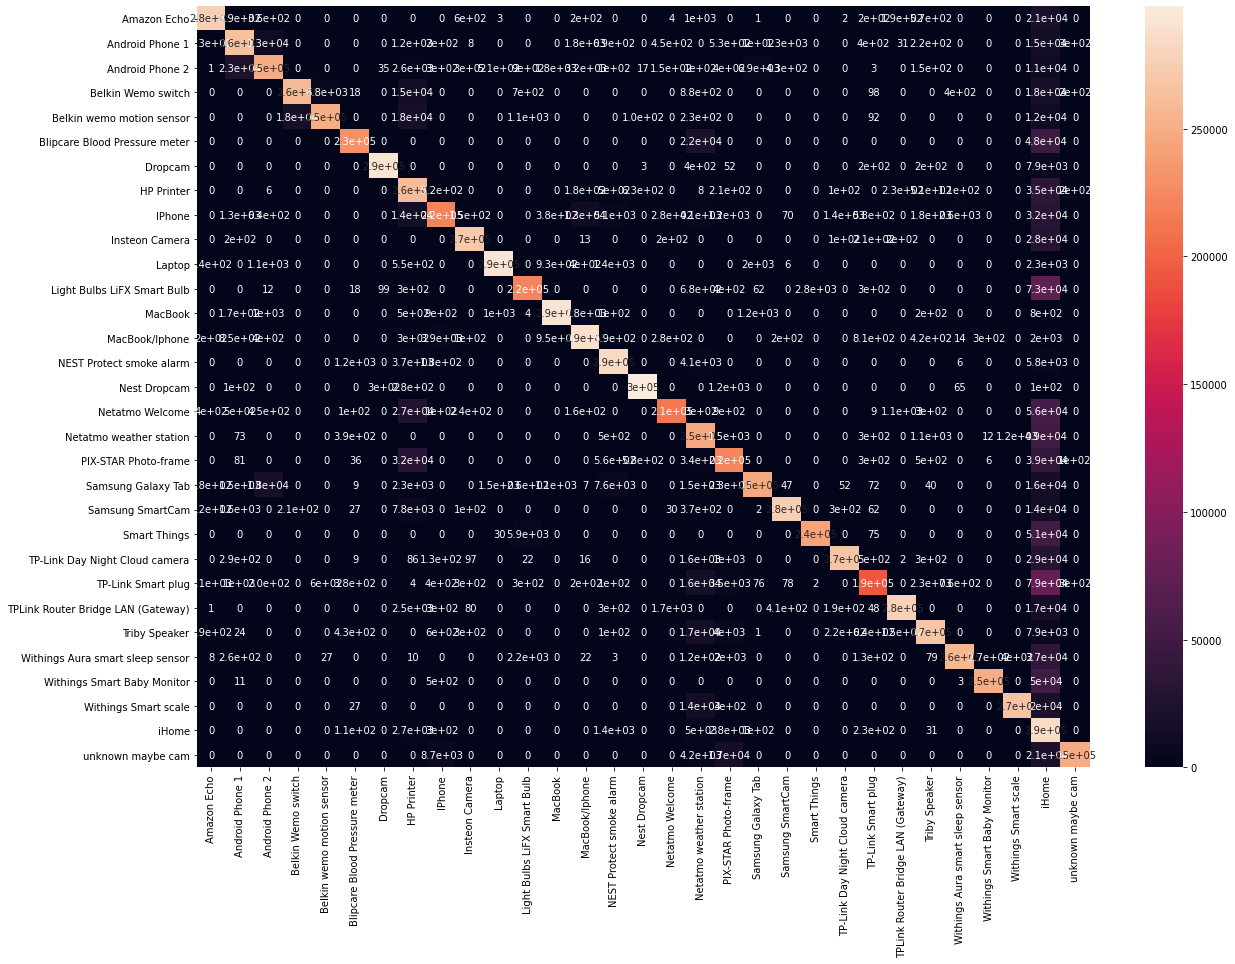

In [12]:
ths = open("1_08_2020_normal.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time),Al-Time)\n")
repetition=100


from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))

for ii in ml_list:
    class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
    cm=pd.DataFrame()
    cv=0
    for i in range(repetition):


        #TRAIN
        df = pd.read_csv(loop)
        m_train=df["Mac"]
        del df["Mac"]
        X_train =df[df.columns[0:-1]]
        X_train=np.array(X_train)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_train=df[df.columns[-1]].cat.codes  

        #TEST
        df = pd.read_csv(loop2)#,header=None )
        m_test=df["Mac"]
        del df["Mac"]
        X_test =df[df.columns[0:-1]]
        X_test=np.array(X_test)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_test=df[df.columns[-1]].cat.codes
        


        dname=loop  
        results_y=[]
        cv+=1
        results_y.append(y_test)


        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        train_time=[]
        test_time=[]
        total_time=[]
        kappa=[]
        accuracy_b=[]

            #machine learning algorithm is applied in this section
        clf = ml_list[ii]#choose algorithm from ml_list dictionary
        second=time.time()
        clf.fit(X_train, y_train)
        train_time.append(float((time.time()-second)) )
        second=time.time()
        predict =clf.predict(X_test)
        test_time.append(float((time.time()-second)) )
        #normal
        lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results)
        #merged
        #predict=merged(m_test,y_test,predict)
        #lines,class_based_results=score(train_time,test_time,predict,y_test,class_based_results)

        ths.write (lines)

        df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
        results_y.append(predict)
        if cm.empty:
            cm =df_cm
        else:
            cm = cm.add(df_cm, fill_value=0)


print(class_based_results/(repetition)) 
graph_name="normal_confusion matrix" +str(ii)+".pdf"          
plt.figure(figsize = (20,14))
sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
plt.show()
#print(cm)
print("\n\n\n") 
ths.close()  

## GROUP SIZE 12

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
h_train_sk.csv  0   1   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.46     1.03    10.49   0.91    
h_train_sk.csv  1   2   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.55     1.03    10.59   0.91    
h_train_sk.csv  2   3   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.62     1.04    10.66   0.9     
h_train_sk.csv  3   4   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.52     1.04    10.56   0.9     
h_train_sk.csv  4   5   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.63     1.05    10.68   0.91    
h_train_sk.csv  5   6   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.52     1.06    10.58   0.9     
h_train_sk.csv  6   7   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.55     1.06    10.61   0.9     
h_train_sk.csv  7   8   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.6      1.04    10.64   0.89    
h_train_sk.csv  8   9   Random  0.99  0.99  1.0   0.99  0.99  0.99  9.64     1.04 

h_train_sk.csv  80  81  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.62     1.04    10.66   0.89    
h_train_sk.csv  81  82  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.42     1.04    10.46   0.9     
h_train_sk.csv  82  83  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.56     1.04    10.6    0.89    
h_train_sk.csv  83  84  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.7      1.04    10.75   0.91    
h_train_sk.csv  84  85  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.42     1.06    10.48   0.9     
h_train_sk.csv  85  86  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.6      1.05    10.64   0.91    
h_train_sk.csv  86  87  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.55     1.03    10.58   0.89    
h_train_sk.csv  87  88  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.87     1.05    10.92   0.9     
h_train_sk.csv  88  89  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.47     1.04    10.51   0.9     
h_train_sk.csv  89  90  Random  0.99  0.99  1.0   0.99  0.99  0.99  9.36     1.04 

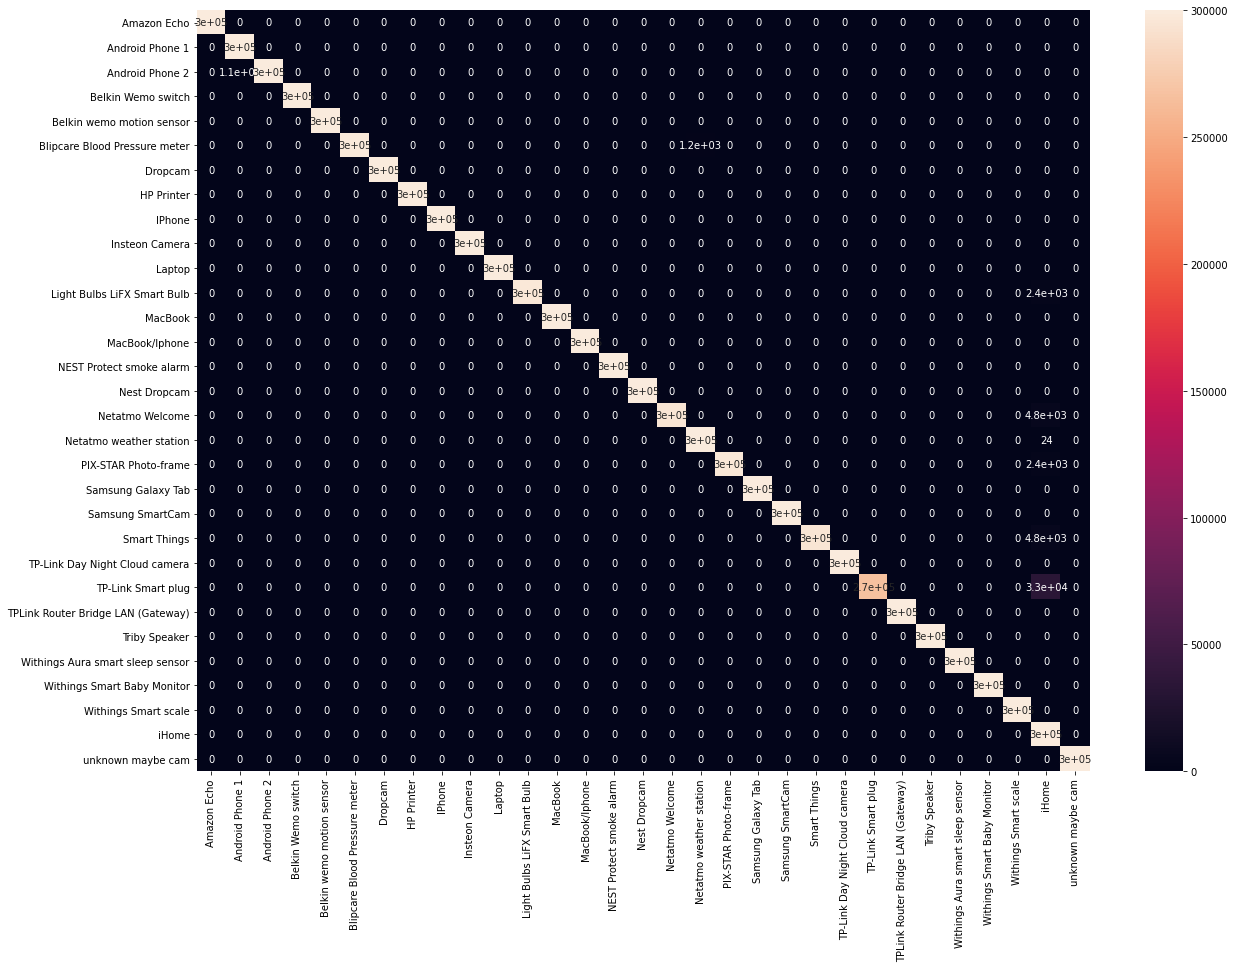

In [13]:
ths = open("1_08_2020_merged_12.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time),Al-Time)\n")
repetition=100


from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))

for ii in ml_list:
    class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
    cm=pd.DataFrame()
    cv=0
    for i in range(repetition):


        #TRAIN
        df = pd.read_csv(loop)
        m_train=df["Mac"]
        del df["Mac"]
        X_train =df[df.columns[0:-1]]
        X_train=np.array(X_train)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_train=df[df.columns[-1]].cat.codes  

        #TEST
        df = pd.read_csv(loop2)#,header=None )
        m_test=df["Mac"]
        del df["Mac"]
        X_test =df[df.columns[0:-1]]
        X_test=np.array(X_test)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_test=df[df.columns[-1]].cat.codes
        


        dname=loop  
        results_y=[]
        cv+=1
        results_y.append(y_test)


        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        train_time=[]
        test_time=[]
        total_time=[]
        kappa=[]
        accuracy_b=[]

            #machine learning algorithm is applied in this section
        clf = ml_list[ii]#choose algorithm from ml_list dictionary
        second=time.time()
        clf.fit(X_train, y_train)
        train_time.append(float((time.time()-second)) )
        second=time.time()
        predict =clf.predict(X_test)
        test_time.append(float((time.time()-second)) )
        #normal
        #lines,class_based_results=score(train_time,test_time,predict,y_test,class_based_results)
        #merged
        predict,altime=merged(m_test,y_test,predict)
        lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results)

        ths.write (lines)






        df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
        results_y.append(predict)
        if cm.empty:
            cm =df_cm
        else:
            cm = cm.add(df_cm, fill_value=0)


print(class_based_results/(repetition)) 
graph_name="merged_confusion matrix" +str(ii)+".pdf"     
plt.figure(figsize = (20,14))
sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
plt.show()
#print(cm)
print("\n\n\n") 
ths.close()  

## GROUP SIZE 9

In [14]:
def merged(mac,y_test,predict):
    step=8
    second=time.time()
    mac_test=[]
    for i in y_test.index:
        mac_test.append(mac[i])

    d_list=sorted(list(mac.unique()))
    devices={}
    for i in d_list:
        devices[i]=[]    


    new_y=[0]*len(y_test)

    for i,ii in enumerate (mac_test):
        devices[ii].append(i)
        #devices[]
    for i in devices:
        
        a = [devices[i][j:j + step] for j in range(0, len(devices[i]), step)]  
        for ii in a:
            step_list=[]
            for iii in ii:
                step_list.append(predict[iii])
            add=most_frequent(list(step_list))
            for iii in ii:
                new_y[iii]=add
                
    return new_y,time.time()-second

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
h_train_sk.csv  0   1   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.44     1.07    10.51   0.93    
h_train_sk.csv  1   2   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.6      1.03    10.64   0.9     
h_train_sk.csv  2   3   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.71     1.04    10.75   0.9     
h_train_sk.csv  3   4   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.47     1.06    10.53   0.9     
h_train_sk.csv  4   5   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.57     1.04    10.61   0.91    
h_train_sk.csv  5   6   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.65     1.06    10.72   0.89    
h_train_sk.csv  6   7   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.49     1.04    10.53   0.91    
h_train_sk.csv  7   8   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.78     1.04    10.82   0.9     
h_train_sk.csv  8   9   Random  0.99  0.99  0.99  0.99  0.99  0.99  9.42     1.05 

h_train_sk.csv  80  81  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.66     1.06    10.72   0.92    
h_train_sk.csv  81  82  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.84     1.06    10.9    0.89    
h_train_sk.csv  82  83  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.56     1.06    10.62   0.92    
h_train_sk.csv  83  84  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.65     1.06    10.7    0.94    
h_train_sk.csv  84  85  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.83     1.04    10.87   0.93    
h_train_sk.csv  85  86  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.71     1.06    10.77   0.9     
h_train_sk.csv  86  87  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.82     1.07    10.89   0.91    
h_train_sk.csv  87  88  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.58     1.06    10.65   0.92    
h_train_sk.csv  88  89  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.65     1.06    10.71   0.91    
h_train_sk.csv  89  90  Random  0.99  0.99  0.99  0.99  0.99  0.99  9.64     1.04 

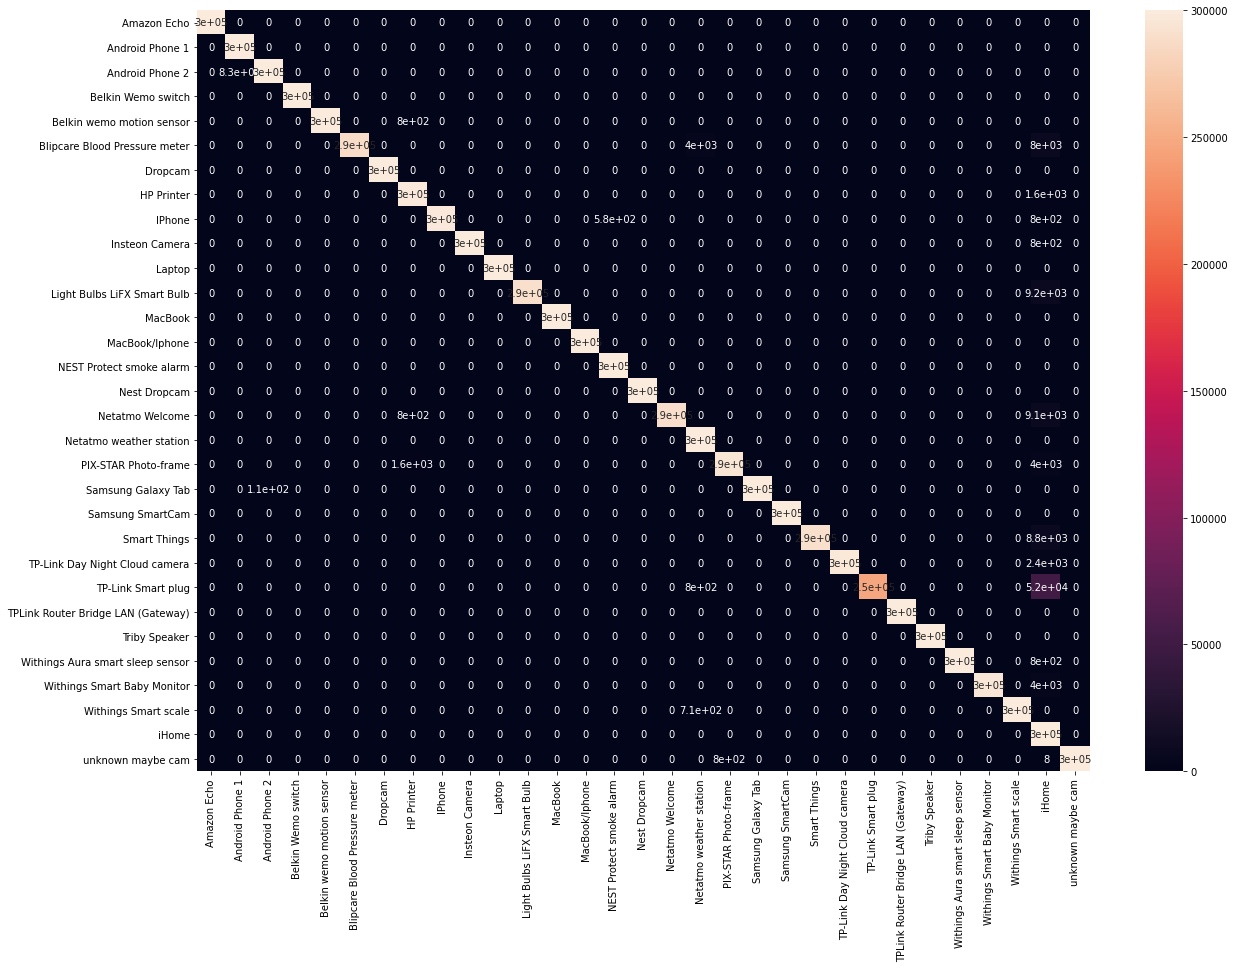

In [15]:
ths = open("1_08_2020_merged_9.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time),Al-Time)\n")
repetition=100


from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))

for ii in ml_list:
    class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
    cm=pd.DataFrame()
    cv=0
    for i in range(repetition):


        #TRAIN
        df = pd.read_csv(loop)
        m_train=df["Mac"]
        del df["Mac"]
        X_train =df[df.columns[0:-1]]
        X_train=np.array(X_train)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_train=df[df.columns[-1]].cat.codes  

        #TEST
        df = pd.read_csv(loop2)#,header=None )
        m_test=df["Mac"]
        del df["Mac"]
        X_test =df[df.columns[0:-1]]
        X_test=np.array(X_test)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_test=df[df.columns[-1]].cat.codes
        


        dname=loop  
        results_y=[]
        cv+=1
        results_y.append(y_test)


        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        train_time=[]
        test_time=[]
        total_time=[]
        kappa=[]
        accuracy_b=[]

            #machine learning algorithm is applied in this section
        clf = ml_list[ii]#choose algorithm from ml_list dictionary
        second=time.time()
        clf.fit(X_train, y_train)
        train_time.append(float((time.time()-second)) )
        second=time.time()
        predict =clf.predict(X_test)
        test_time.append(float((time.time()-second)) )
        #normal
        #lines,class_based_results=score(train_time,test_time,predict,y_test,class_based_results)
        #merged
        predict,altime=merged(m_test,y_test,predict)
        lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results)

        ths.write (lines)






        df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
        results_y.append(predict)
        if cm.empty:
            cm =df_cm
        else:
            cm = cm.add(df_cm, fill_value=0)


print(class_based_results/(repetition)) 
graph_name="merged_confusion matrix" +str(ii)+".pdf"     
plt.figure(figsize = (20,14))
sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
plt.show()
#print(cm)
print("\n\n\n") 
ths.close()  

## GROUP SIZE 6

In [16]:
def merged(mac,y_test,predict):
    step=6
    second=time.time()
    mac_test=[]
    for i in y_test.index:
        mac_test.append(mac[i])

    d_list=sorted(list(mac.unique()))
    devices={}
    for i in d_list:
        devices[i]=[]    


    new_y=[0]*len(y_test)

    for i,ii in enumerate (mac_test):
        devices[ii].append(i)
        #devices[]
    for i in devices:
        
        a = [devices[i][j:j + step] for j in range(0, len(devices[i]), step)]  
        for ii in a:
            step_list=[]
            for iii in ii:
                step_list.append(predict[iii])
            add=most_frequent(list(step_list))
            for iii in ii:
                new_y[iii]=add
                
    return new_y,time.time()-second

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
h_train_sk.csv  0   1   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.59     1.04    10.63   0.91    
h_train_sk.csv  1   2   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.7      1.04    10.74   0.93    
h_train_sk.csv  2   3   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.65     1.04    10.69   0.92    
h_train_sk.csv  3   4   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.58     1.04    10.62   0.9     
h_train_sk.csv  4   5   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.52     1.06    10.58   0.91    
h_train_sk.csv  5   6   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.77     1.04    10.81   0.92    
h_train_sk.csv  6   7   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.57     1.1     10.67   0.91    
h_train_sk.csv  7   8   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.7      1.06    10.76   0.9     
h_train_sk.csv  8   9   Random  0.98  0.98  0.99  0.98  0.98  0.98  9.45     1.06 

h_train_sk.csv  80  81  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.23     1.04    10.27   0.9     
h_train_sk.csv  81  82  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.57     1.04    10.61   0.92    
h_train_sk.csv  82  83  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.6      1.03    10.63   0.92    
h_train_sk.csv  83  84  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.59     1.03    10.63   0.91    
h_train_sk.csv  84  85  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.58     1.06    10.64   0.91    
h_train_sk.csv  85  86  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.58     1.05    10.64   0.9     
h_train_sk.csv  86  87  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.47     1.05    10.53   0.91    
h_train_sk.csv  87  88  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.64     1.06    10.71   0.91    
h_train_sk.csv  88  89  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.36     1.06    10.42   0.91    
h_train_sk.csv  89  90  Random  0.98  0.98  0.99  0.98  0.98  0.98  9.89     1.04 

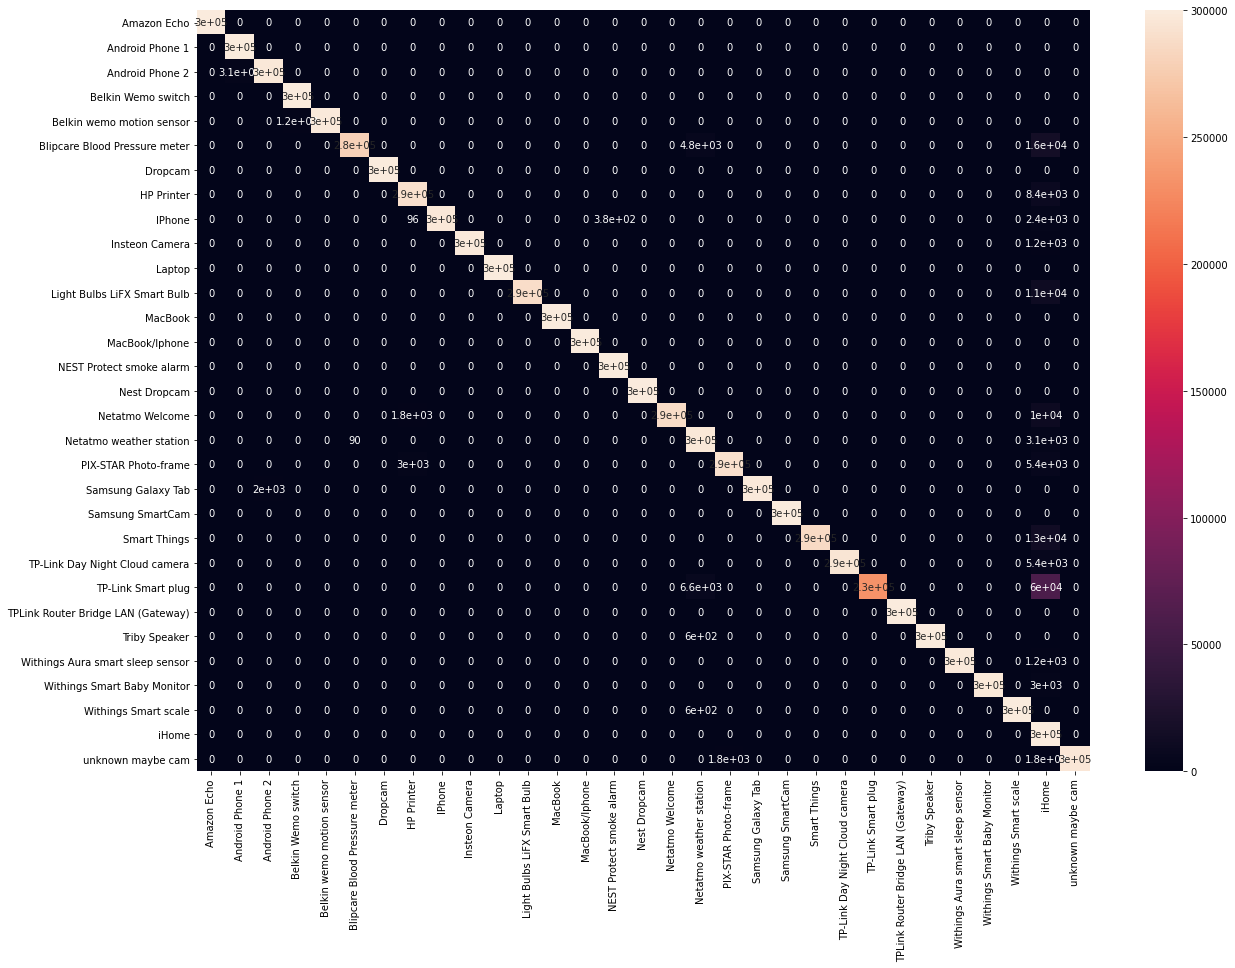

In [17]:
ths = open("1_08_2020_merged_6.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time),Al-Time)\n")
repetition=100


from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))

for ii in ml_list:
    class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
    cm=pd.DataFrame()
    cv=0
    for i in range(repetition):


        #TRAIN
        df = pd.read_csv(loop)
        m_train=df["Mac"]
        del df["Mac"]
        X_train =df[df.columns[0:-1]]
        X_train=np.array(X_train)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_train=df[df.columns[-1]].cat.codes  

        #TEST
        df = pd.read_csv(loop2)#,header=None )
        m_test=df["Mac"]
        del df["Mac"]
        X_test =df[df.columns[0:-1]]
        X_test=np.array(X_test)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_test=df[df.columns[-1]].cat.codes
        


        dname=loop  
        results_y=[]
        cv+=1
        results_y.append(y_test)


        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        train_time=[]
        test_time=[]
        total_time=[]
        kappa=[]
        accuracy_b=[]

            #machine learning algorithm is applied in this section
        clf = ml_list[ii]#choose algorithm from ml_list dictionary
        second=time.time()
        clf.fit(X_train, y_train)
        train_time.append(float((time.time()-second)) )
        second=time.time()
        predict =clf.predict(X_test)
        test_time.append(float((time.time()-second)) )
        #normal
        #lines,class_based_results=score(train_time,test_time,predict,y_test,class_based_results)
        #merged
        predict,altime=merged(m_test,y_test,predict)
        lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results)

        ths.write (lines)






        df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
        results_y.append(predict)
        if cm.empty:
            cm =df_cm
        else:
            cm = cm.add(df_cm, fill_value=0)


print(class_based_results/(repetition)) 
graph_name="merged_confusion matrix" +str(ii)+".pdf"     
plt.figure(figsize = (20,14))
sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
plt.show()
#print(cm)
print("\n\n\n") 
ths.close()  

## GROUP SIZE 3

In [18]:
def merged(mac,y_test,predict):
    step=3
    second=time.time()
    mac_test=[]
    for i in y_test.index:
        mac_test.append(mac[i])

    d_list=sorted(list(mac.unique()))
    devices={}
    for i in d_list:
        devices[i]=[]    


    new_y=[0]*len(y_test)

    for i,ii in enumerate (mac_test):
        devices[ii].append(i)
        #devices[]
    for i in devices:
        
        a = [devices[i][j:j + step] for j in range(0, len(devices[i]), step)]  
        for ii in a:
            step_list=[]
            for iii in ii:
                step_list.append(predict[iii])
            add=most_frequent(list(step_list))
            for iii in ii:
                new_y[iii]=add
                
    return new_y,time.time()-second

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1    kap   tra-T    test-T  total   al-time 
h_train_sk.csv  0   1   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.72     1.08    10.79   0.92    
h_train_sk.csv  1   2   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.59     1.06    10.65   0.95    
h_train_sk.csv  2   3   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.85     1.06    10.91   0.99    
h_train_sk.csv  3   4   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.64     1.07    10.71   0.91    
h_train_sk.csv  4   5   Random  0.95  0.95  0.96  0.95  0.95  0.94  9.75     1.05    10.81   0.92    
h_train_sk.csv  5   6   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.63     1.06    10.69   0.92    
h_train_sk.csv  6   7   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.43     1.06    10.5    0.94    
h_train_sk.csv  7   8   Random  0.95  0.95  0.96  0.95  0.95  0.94  9.66     1.04    10.7    0.91    
h_train_sk.csv  8   9   Random  0.95  0.95  0.96  0.95  0.95  0.95  9.62     1.06 

h_train_sk.csv  80  81  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.5      1.04    10.54   0.96    
h_train_sk.csv  81  82  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.77     1.06    10.83   0.92    
h_train_sk.csv  82  83  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.75     1.04    10.78   0.91    
h_train_sk.csv  83  84  Random  0.95  0.95  0.96  0.95  0.95  0.94  9.48     1.05    10.53   0.92    
h_train_sk.csv  84  85  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.65     1.06    10.72   0.95    
h_train_sk.csv  85  86  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.56     1.04    10.6    0.94    
h_train_sk.csv  86  87  Random  0.95  0.95  0.97  0.95  0.95  0.95  9.62     1.05    10.67   0.91    
h_train_sk.csv  87  88  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.52     1.06    10.58   0.92    
h_train_sk.csv  88  89  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.56     1.04    10.6    0.96    
h_train_sk.csv  89  90  Random  0.95  0.95  0.96  0.95  0.95  0.95  9.7      1.04 

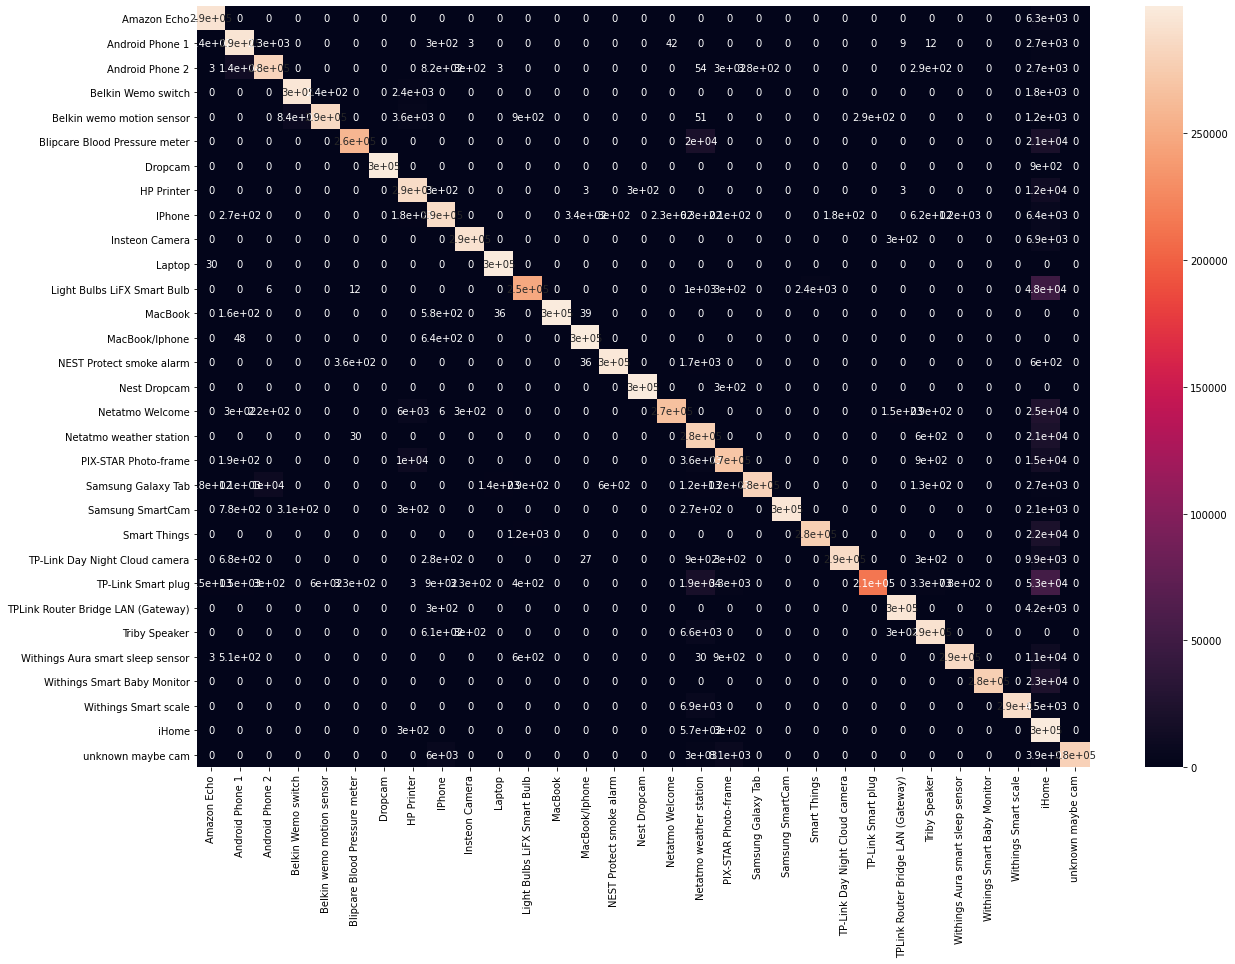

In [19]:
ths = open("1_08_2020_merged_3.csv", "w")
ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,total-Time),Al-Time)\n")
repetition=100


from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import Normalizer
print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-5s %-5s %-8s %-8s%-8s%-8s'%
           ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))

for ii in ml_list:
    class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
    cm=pd.DataFrame()
    cv=0
    for i in range(repetition):


        #TRAIN
        df = pd.read_csv(loop)
        m_train=df["Mac"]
        del df["Mac"]
        X_train =df[df.columns[0:-1]]
        X_train=np.array(X_train)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_train=df[df.columns[-1]].cat.codes  

        #TEST
        df = pd.read_csv(loop2)#,header=None )
        m_test=df["Mac"]
        del df["Mac"]
        X_test =df[df.columns[0:-1]]
        X_test=np.array(X_test)
        df[df.columns[-1]] = df[df.columns[-1]].astype('category')
        y_test=df[df.columns[-1]].cat.codes
        


        dname=loop  
        results_y=[]
        cv+=1
        results_y.append(y_test)


        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        train_time=[]
        test_time=[]
        total_time=[]
        kappa=[]
        accuracy_b=[]

            #machine learning algorithm is applied in this section
        clf = ml_list[ii]#choose algorithm from ml_list dictionary
        second=time.time()
        clf.fit(X_train, y_train)
        train_time.append(float((time.time()-second)) )
        second=time.time()
        predict =clf.predict(X_test)
        test_time.append(float((time.time()-second)) )
        #normal
        #lines,class_based_results=score(train_time,test_time,predict,y_test,class_based_results)
        #merged
        predict,altime=merged(m_test,y_test,predict)
        lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results)

        ths.write (lines)






        df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
        results_y.append(predict)
        if cm.empty:
            cm =df_cm
        else:
            cm = cm.add(df_cm, fill_value=0)


print(class_based_results/(repetition)) 
graph_name="merged_confusion matrix" +str(ii)+".pdf"     
plt.figure(figsize = (20,14))
sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True)
plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
plt.show()
#print(cm)
print("\n\n\n") 
ths.close()  